In [5]:
# !pip uninstall gym

In [6]:
# !pip install gym==0.25.0

In [7]:
# please install gym with version of 0.25. 
# python must be 3.11 in order to install tensorFlow

# Import Dependencies

In [8]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
from collections import deque
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from base64 import b64encode
from IPython.display import HTML, display
import os


if not hasattr(np, "bool8"):
    np.bool8 = np.bool_


## Loading CartPole Environment

In [9]:
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)

# Inside Box([min], [max])
# min[cart_position, cart_velovity, pole_angle, angular_velocity]
# max[cart_position, cart_velovity, pole_angle, angular_velocity]

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


## Initial Observation

In [10]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.03807477  0.04682717  0.01292162 -0.04501261]


In [11]:
observation, reward, done, info = env.step(0)
def printInfo(observation, reward, done):
    print("New observations after choosing action 0:", observation)
    print("Reward for this step:", reward)
    print("Is this round done?", done)

## The 'Always Choose Zero' strategy

In [12]:
# Always Choose zero strategy
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    printInfo(observation, reward, done)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

New observations after choosing action 0: [-0.01780059 -0.19471914 -0.00750788  0.30989543]
Reward for this step: 1.0
Is this round done? False
New observations after choosing action 0: [-0.02169497 -0.3897333  -0.00130997  0.60020113]
Reward for this step: 1.0
Is this round done? False
New observations after choosing action 0: [-0.02948963 -0.5848369   0.01069406  0.8924712 ]
Reward for this step: 1.0
Is this round done? False
New observations after choosing action 0: [-0.04118637 -0.78010225  0.02854348  1.1884965 ]
Reward for this step: 1.0
Is this round done? False
New observations after choosing action 0: [-0.05678842 -0.97558236  0.05231341  1.4899879 ]
Reward for this step: 1.0
Is this round done? False
New observations after choosing action 0: [-0.07630007 -1.1713008   0.08211316  1.798537  ]
Reward for this step: 1.0
Is this round done? False
New observations after choosing action 0: [-0.09972608 -1.3672398   0.1180839   2.1155694 ]
Reward for this step: 1.0
Is this round done

## Task 1: Development of Q-Learning Based RL Agent

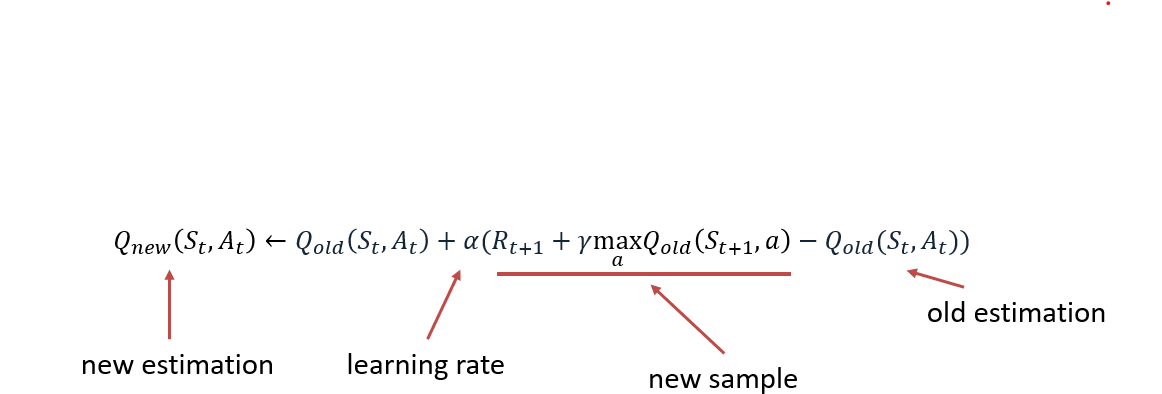

## Define Discretization Functions

In [25]:
def create_bins(num_bins, lower_bounds, upper_bounds):
    """Create discretization bins for each state dimension."""
    # Discretization converts a continuous state space into a limited number of “buckets” or bins
    bins = []
    for i in range(len(num_bins)):
        # Create num_bins[i]-1 cut points between lower and upper bound
        bins.append(np.linspace(lower_bounds[i], upper_bounds[i], num_bins[i] - 1))
    return bins

def discretize_state(state, bins):
    """Convert a continuous state into its discretized tuple."""
    return tuple(np.digitize(s, b) for s, b in zip(state, bins))


## Q‑Learning Training Function

In [32]:
def train_qlearning_agent(
    env,
    num_bins=(10, 10, 30, 30),
    alpha=0.1,
    gamma=0.99,
    epsilon=0.85,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    max_steps=500,
    max_episodes=10000,
    target_avg_reward=500
):
    """
    Train a Q-learning agent on the given environment.
    
    Returns:
      Q - the learned Q-table.
      bins - the discretization bins.
    """
    # Get observation space bounds and adjust unbounded values
    obs_space = env.observation_space
    lower_bounds = obs_space.low.copy()
    upper_bounds = obs_space.high.copy()
    
    # Clip cart velocity and pole angular velocity to a reasonable range
    # Q-learning algorithm works best with a finite set of states. So we set a practical velocity for the training 
    lower_bounds[1] = -5
    upper_bounds[1] = 5
    lower_bounds[3] = -5
    upper_bounds[3] = 5

    # Create discretization bins and initialize Q-table
    bins = create_bins(num_bins, lower_bounds, upper_bounds)
    q_table_shape = num_bins + (env.action_space.n,)
    Q = np.zeros(q_table_shape)

    # For tracking recent rewards (last 100 episodes)
    rewards_deque = deque(maxlen=100)
    episode = 0

    # while episode < max_episodes:
    while True:
        episode += 1
        state = env.reset()
        state_disc = discretize_state(state, bins)
        cumulative_reward = 0
        done = False

        for _ in range(max_steps):
            # ε-greedy action selection:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Exploration
            else:
                action = np.argmax(Q[state_disc])    # Exploitation

            next_state, reward, done, _ = env.step(action)
            cumulative_reward += reward

            # Discretize the next state and perform Q-learning update
            next_state_disc = discretize_state(next_state, bins)
            best_next_q = np.max(Q[next_state_disc])
            Q[state_disc + (action,)] += alpha * (reward + gamma * best_next_q - Q[state_disc + (action,)])
            
            state_disc = next_state_disc
            if done:
                break

        # Decay epsilon and record reward
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_deque.append(cumulative_reward)

        if episode % 1000 == 0:
            avg_reward = np.mean(rewards_deque)
            print(f"Episode {episode}: Reward = {cumulative_reward}, Average (last 100) = {avg_reward:.2f}")

        # Stop training if the agent performs well on average over the last 100 episodes
        if len(rewards_deque) == 100 and np.mean(rewards_deque) >= target_avg_reward:
            print(f"Solved in episode {episode} with an average reward of {np.mean(rewards_deque):.2f}!")
            break

    return Q, bins


## Q‑Learning Agent Evaluation Function with Video Recording

In [33]:
def evaluate_qlearning_agent(
    env,
    Q,
    bins,
    max_steps=500,
    num_episodes=100,
    video_folder='videos'
):
    """
    Evaluate the trained Q-learning agent.
    
    Records a video for each of the evaluation episodes using Gym's RecordVideo.
    Returns the rewards for each episode.
    """
    from gym.wrappers import RecordVideo

    # Ensure video folder exists
    if not os.path.exists(video_folder):
        os.makedirs(video_folder)

    # Wrap the environment for video recording.
    # The lambda triggers recording on every episode.
    env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda ep: True, name_prefix="episode")

    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        state_disc = discretize_state(state, bins)
        cumulative_reward = 0
        done = False

        for _ in range(max_steps):
            # Always take the best action (no exploration)
            action = np.argmax(Q[state_disc])
            next_state, reward, done, _ = env.step(action)
            cumulative_reward += reward
            state_disc = discretize_state(next_state, bins)
            if done:
                break

        rewards.append(cumulative_reward)
        print(f"Evaluation Episode {episode+1}: Reward = {cumulative_reward}")

    env.close()
    avg_reward = np.mean(rewards)
    print(f"Average reward over {num_episodes} episodes: {avg_reward:.2f}")
    return rewards


# Training Phase

In [34]:
env_training = gym.make("CartPole-v1")
Q, bins = train_qlearning_agent(env_training)
env_training.close()

Episode 1000: Reward = 37.0, Average (last 100) = 47.91
Episode 2000: Reward = 18.0, Average (last 100) = 67.30
Episode 3000: Reward = 95.0, Average (last 100) = 116.34
Episode 4000: Reward = 22.0, Average (last 100) = 89.58
Episode 5000: Reward = 500.0, Average (last 100) = 139.39
Episode 6000: Reward = 500.0, Average (last 100) = 155.02
Episode 7000: Reward = 500.0, Average (last 100) = 367.83
Episode 8000: Reward = 500.0, Average (last 100) = 452.59
Episode 9000: Reward = 500.0, Average (last 100) = 474.49
Episode 10000: Reward = 500.0, Average (last 100) = 470.43
Episode 11000: Reward = 85.0, Average (last 100) = 388.72
Solved in episode 11367 with an average reward of 500.00!


## Evaluation Phase

In [35]:
# env_eval = gym.make("CartPole-v1")
# evaluation_rewards = evaluate_q_agent(env_eval, Q, bins, max_steps=500, eval_episodes=100)
# env_eval.close()

# avg_reward = np.mean(evaluation_rewards)
# print(f"Average Reward over 100 evaluation episodes: {avg_reward:.2f}")

In [36]:
from gym.wrappers import RecordVideo

# Create a new evaluation environment with video recording enabled.
video_folder = "evaluation_videos"
env_evaluation = gym.make("CartPole-v1")
env_evaluation = RecordVideo(env_evaluation,
                             video_folder=video_folder,
                             episode_trigger=lambda ep: True,  # record every episode
                             name_prefix="evaluation")

max_steps=500
eval_episodes = 100
evaluation_rewards = []

# Set epsilon to 0 to ensure pure exploitation
epsilon = 0.0

for ep in range(1, eval_episodes + 1):
    state = env_evaluation.reset()
    state_disc = discretize_state(state, bins)
    cumulative_reward = 0
    done = False

    for step in range(max_steps):
        # Pure exploitation: select the best action from Q-table
        action = np.argmax(Q[state_disc])
        next_state, reward, done, info = env_evaluation.step(action)
        cumulative_reward += reward
        state_disc = discretize_state(next_state, bins)
        if done:
            break

    evaluation_rewards.append(cumulative_reward)
    print(f"Evaluation Episode {ep}: Reward = {cumulative_reward}")

env_evaluation.close()

avg_reward = np.mean(evaluation_rewards)
print(f"Average Reward over {eval_episodes} evaluation episodes: {avg_reward:.2f}")

Evaluation Episode 1: Reward = 500.0
Evaluation Episode 2: Reward = 500.0
Evaluation Episode 3: Reward = 500.0
Evaluation Episode 4: Reward = 500.0
Evaluation Episode 5: Reward = 500.0
Evaluation Episode 6: Reward = 500.0
Evaluation Episode 7: Reward = 500.0
Evaluation Episode 8: Reward = 500.0
Evaluation Episode 9: Reward = 500.0
Evaluation Episode 10: Reward = 500.0
Evaluation Episode 11: Reward = 500.0
Evaluation Episode 12: Reward = 500.0
Evaluation Episode 13: Reward = 500.0
Evaluation Episode 14: Reward = 500.0
Evaluation Episode 15: Reward = 500.0
Evaluation Episode 16: Reward = 500.0
Evaluation Episode 17: Reward = 500.0
Evaluation Episode 18: Reward = 500.0
Evaluation Episode 19: Reward = 500.0
Evaluation Episode 20: Reward = 500.0
Evaluation Episode 21: Reward = 500.0
Evaluation Episode 22: Reward = 500.0
Evaluation Episode 23: Reward = 500.0
Evaluation Episode 24: Reward = 500.0
Evaluation Episode 25: Reward = 500.0
Evaluation Episode 26: Reward = 500.0
Evaluation Episode 27

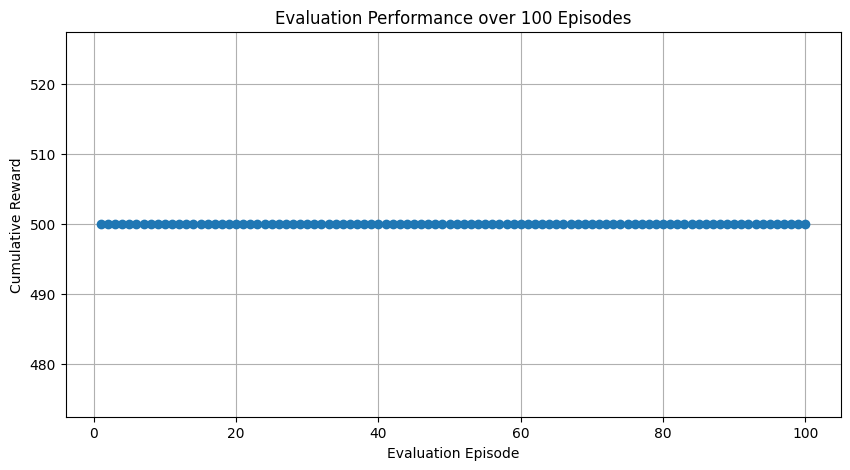

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), evaluation_rewards, marker='o', linestyle='-')
plt.xlabel("Evaluation Episode")
plt.ylabel("Cumulative Reward")
plt.title("Evaluation Performance over 100 Episodes")
plt.grid(True)
plt.show()